In [157]:
! gymnasium>=1.0.0
! pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

zsh:1: 1.0.0 not found
  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /private/var/folders/dl/9bz5fwk55z906gm27_x9mgbc0000gn/T/pip-req-build-nwko0jc8
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /private/var/folders/dl/9bz5fwk55z906gm27_x9mgbc0000gn/T/pip-req-build-nwko0jc8
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done


In [158]:
import numpy as np
from collections import defaultdict
import gymnasium as gym
import text_flappy_bird_gym
import matplotlib.pyplot as plt
import os
import sys
import time
from typing import Dict, Tuple
import random
from collections import deque


#### 0. BASE AGENT CLASS 


In [ ]:
class BaseAgent:
    """Base class for RL agents with common functionality"""
    def __init__(self, env, gamma: float = 0.99, alpha: float = 0.1, 
                 lambda_: float = 0.7, epsilon: float = 1.0, 
                 epsilon_min: float = 0.01, temp: float = 1.0, 
                 optimistic_init: float = 0.0):
        """
        Initialize base agent parameters
        
        Args:
            env: Gym environment
            gamma: Discount factor
            alpha: Learning rate
            lambda_: Eligibility trace decay (if applicable)
            epsilon: Exploration rate
            epsilon_min: Minimum exploration rate
            temp: Temperature for Boltzmann exploration (if applicable)
            optimistic_init: Initial Q-value for optimistic initialization
        """
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.lambda_ = lambda_
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.temp = temp
        
        # Initialize Q-values and policy
        self.Q = defaultdict(lambda: np.ones(env.action_space.n) * optimistic_init)
        self.policy = {}
        
        # Episode tracking
        self.current_state = None
        self.current_action = None
        self.episode_rewards = []
        self.training_history = []
        
    def get_action(self, state: Tuple[int, int]) -> int:
        """Epsilon-greedy policy for action selection"""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.Q[state])
    
    def boltzmann_exploration(self, state: Tuple[int, int]) -> int:
        """Boltzmann exploration for action selection"""
        q_values = self.Q[state]
        probabilities = np.exp(q_values / self.temp) / np.sum(np.exp(q_values / self.temp))
        return np.random.choice(len(q_values), p=probabilities)
    
    def decay_exploration(self, episode: int):
        """Decay exploration parameters over time"""
        self.epsilon = max(self.epsilon_min, self.epsilon * 0.995)
        self.temp = max(0.1, self.temp * 0.995)
        
    def start_episode(self, state: Tuple[int, int]) -> int:
        """Initialize episode-specific variables"""
        self.current_state = state
        self.current_action = self.get_action(state)
        return self.current_action
    
    def update_policy(self):
        """Update the greedy policy based on current Q-values"""
        self.policy = {s: np.argmax(q) for s, q in self.Q.items()}
        
    def train(self, episodes: int = 1000) -> list:
        """Training loop to be implemented by subclasses"""
        raise NotImplementedError
        

#### A. MONTE CARLO AGENT

In [ ]:
class MonteCarloAgent(BaseAgent):
    
    def __init__(self, env, gamma=0.99, alpha=0.1, epsilon=1.0, 
                 epsilon_min=0.1, temp=1.0, use_boltzmann=False, 
                 optimistic_init=1.0):
        super().__init__(
            env=env,
            gamma=gamma,
            alpha=alpha,
            lambda_=0,  
            epsilon=epsilon,
            epsilon_min=epsilon_min,
            temp=temp,
            optimistic_init=optimistic_init
        )
        self.use_boltzmann = use_boltzmann
        self.returns = defaultdict(list)
        self.state_action_counts = defaultdict(int)
    
    def _state_to_key(self, state):
        return state

    def get_action(self, state):
        """Epsilon-greedy action selection"""
        state_key = self._state_to_key(state)
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.Q[state_key])
    
    def run_episode(self):
        """Generate an episode using current policy"""
        states, actions, rewards = [], [], []
        state, _ = self.env.reset()
        done = False
        
        while not done:
            action = self.get_action(state)
            next_state, reward, done, _, _ = self.env.step(action)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            
            state = next_state
            
        return states, actions, rewards
    
    def update_q_values(self, states, actions, rewards):
        """First-visit MC update with learning rate adjustment"""
        G = 0  
        visited = set()  
        
        for t in reversed(range(len(states))):
            state, action, reward = states[t], actions[t], rewards[t]
            G = self.gamma * G + reward
            
            if (state, action) not in visited:
                visited.add((state, action))
                self.state_action_counts[(state, action)] += 1
                self.returns[(state, action)].append(G)
                
                # Calculate the learning rate
                n = self.state_action_counts[(state, action)]
                learning_rate = self.alpha / (1 + 0.001 * n)
                
                # Update Q-value
                self.Q[state][action] = np.mean(self.returns[(state, action)])
    
    def get_q_table(self):
        """Return the learned Q-table"""
        return self.Q
    
    def train(self, episodes=1000, report_interval=100,print_progression=True):
        """Complete training method with progress tracking"""
        self.training_history = []
        best_avg = -np.inf
        if print_progression:
            print(f"Training for {episodes} episodes")
            print("Episode | Reward | Avg100 | ε | Temp")
            print("------------------------------------")
        
        for ep in range(1, episodes + 1):
            states, actions, rewards = self.run_episode()
            self.update_q_values(states, actions, rewards)
            
            total_reward = sum(rewards)
            self.training_history.append(total_reward)
            self.decay_exploration(ep)
            
            # Progress reporting
            if ep % report_interval == 0 or ep == 1:
                avg100 = np.mean(self.training_history[-100:]) if len(self.training_history) >= 100 else 0
                best_avg = max(best_avg, avg100)
                if print_progression:
                    print(f"{ep:6} | {total_reward:6.1f} | {avg100:6.1f} | {self.epsilon:.2f} | {self.temp:.2f}")
        
        self.update_policy()
        return self.training_history

#### B. SARSA(λ) AGENT

In [ ]:
class SarsaLambdaAgent(BaseAgent):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.z = defaultdict(lambda: np.zeros(self.env.action_space.n))  # Eligibility traces
        self.best_reward = -np.inf  # Track best performance
        
    def start_episode(self, state: Tuple[int, int]) -> int:
        """Initialize eligibility traces for new episode"""
        self.z = defaultdict(lambda: np.zeros(self.env.action_space.n))
        return super().start_episode(state)
        
    def update(self, state: Tuple[int, int], action: int, reward: float, 
               next_state: Tuple[int, int], done: bool) -> int:
        """SARSA(λ) update with eligibility traces"""
        next_action = self.get_action(next_state)
        
        # TD error
        td_error = reward + self.gamma * self.Q[next_state][next_action] * (not done) - \
                  self.Q[state][action]
        
        # Update eligibility traces 
        self.z[state][action] += 1
        
        # Update all states
        for s in self.z:
            for a in range(self.env.action_space.n):
                self.Q[s][a] += self.alpha * td_error * self.z[s][a]
                self.z[s][a] *= self.gamma * self.lambda_
        
        return next_action
    
    def get_q_table(self):
        """Return the learned Q-table"""
        return self.Q
    
    def train(self, episodes: int = 1000, report_interval: int = 100, print_progression=True) -> list:
    
        self.training_history = []

        if print_progression:
            print(f"Training for {episodes} episodes")
            print("Episode | Reward | Avg100 | Best")
            print("--------------------------------")
        
        for ep in range(1, episodes + 1):
            state, _ = self.env.reset()
            action = self.start_episode(state)
            done = False
            total_reward = 0
            
            while not done:
                next_state, reward, done, _, _ = self.env.step(action)
                total_reward += reward
                action = self.update(state, action, reward, next_state, done)
                state = next_state
            
            # Update tracking
            self.decay_exploration(ep)
            self.training_history.append(total_reward)
            self.best_reward = max(self.best_reward, total_reward)
            
            # Progress reporting
            if ep % report_interval == 0 or ep == 1 or ep == episodes:
                avg100 = np.mean(self.training_history[-100:]) if len(self.training_history) >= 100 else 0
                if print_progression:
                    print(f"{ep:6} | {total_reward:6.1f} | {avg100:6.1f} | "f"{self.best_reward:4.0f}")
        
        self.update_policy()
        return self.training_history

#### C. TRAINING 

In [ ]:
def train_agents(env, episodes: int = 1000):
    print("=== Training Monte Carlo Agent ===")
    mc_agent = MonteCarloAgent(
        env,
        gamma=0.99,
        alpha=0.2,  
        epsilon=1.0,
        epsilon_min=0.01,
        optimistic_init=1.0
    )
    mc_rewards = mc_agent.train(episodes,print_progression=True)
    
    print("\n=== Training SARSA(λ) Agent ===")
    sarsa_agent = SarsaLambdaAgent(
        env,
        gamma=0.99,
        alpha=0.1,
        lambda_=0.8,
        epsilon=1.0,
        epsilon_min=0.01
    )
    sarsa_rewards = sarsa_agent.train(episodes,print_progression=True)
    
    return mc_agent, sarsa_agent, mc_rewards, sarsa_rewards

#### D. VISUALIZATION & UTILITY FUNCTIONS

In [ ]:
def moving_average(data, window):
    """Compute moving average with proper window handling"""
    if window > len(data):
        return np.array([])
    return np.convolve(data, np.ones(min(window, 100))/min(window, 100), mode='valid')

def plot_training_curves(mc_rewards, sarsa_rewards,  window=50):
    
    plt.figure(figsize=(12, 6))
    
    # Plot raw data with transparency
    #plt.plot(mc_rewards, alpha=0.1, color='blue')
    #plt.plot(sarsa_rewards, alpha=0.1, color='green')
    
    # Plot smoothed data with safe window sizes
    window = min(window, len(mc_rewards)//2)  # Ensure window isn't too large
    
    if len(mc_rewards) >= window:
        plt.plot(moving_average(mc_rewards, window), 
                label='Monte Carlo', color='blue')
    if len(sarsa_rewards) >= window:
        plt.plot(moving_average(sarsa_rewards, window), 
                label='SARSA(λ)', color='green')
    
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Performance Comparison')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def plot_agent_visualizations(agent, max_dx: int = 20, max_dy: int = 15) -> None:
    """
    Combined visualization of state values and policy in subplots
    
    Args:
        agent: The trained agent (MonteCarloAgent or SarsaLambdaAgent)
        max_dx: Maximum horizontal distance to visualize
        max_dy: Maximum vertical distance to visualize
    """
    agent_name = agent.__class__.__name__
    
    plt.figure(figsize=(20, 8))
    plt.suptitle(f'{agent_name}', y=1.05, fontsize=13, fontweight='bold')
    
    dx_values = range(-max_dx, max_dx + 1)
    dy_values = range(-max_dy, max_dy + 1)
    
    value_grid = np.zeros((len(dy_values), len(dx_values)))
    policy_grid = np.zeros((len(dy_values), len(dx_values)))
    
    for i, dy in enumerate(dy_values):
        for j, dx in enumerate(dx_values):
            state = (dx, dy)
            value_grid[i, j] = np.max(agent.Q[state])
            policy_grid[i, j] = agent.policy.get(state, 0)
    
    # State-Value Subplot
    plt.subplot(1, 2, 1)
    img1 = plt.imshow(value_grid, cmap='viridis', 
                    extent=[-max_dx, max_dx, -max_dy, max_dy], 
                    aspect='auto')
    plt.colorbar(img1, label='State Value', fraction=0.046, pad=0.04)
    plt.xlabel('Horizontal Distance (dx)')
    plt.ylabel('Vertical Distance (dy)')
    plt.title('State-Value Function')
    
    # Policy Subplot
    plt.subplot(1, 2, 2)
    img2 = plt.imshow(policy_grid, cmap='coolwarm', 
                    extent=[-max_dx, max_dx, -max_dy, max_dy], 
                    aspect='auto')
    cbar = plt.colorbar(img2, ticks=[0, 1], label='Action (0=no flap, 1=flap)', 
                       fraction=0.046, pad=0.04)
    cbar.ax.set_yticklabels(['No flap', 'Flap'])
    plt.xlabel('Horizontal Distance (dx)')
    plt.ylabel('Vertical Distance (dy)')
    plt.title('Policy Visualization')
    
    plt.tight_layout()
    plt.show()

In [ ]:
def render_trained_agent(env, agent, max_reward: float = 1000, delay: float = 0.1) -> None:
    """Render the agent playing the game with visualization"""
    obs, _ = env.reset()
    done = False
    total_reward = 0

    os.system("clear")
    print("Rendering trained agent (press Ctrl+C to stop)...")

    while not done and total_reward < max_reward:
        time.sleep(delay)
        state = obs
        action = agent.policy.get(tuple(state), 0)  # Default 0 to no flap if state not in policy
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward
        
        os.system("clear")
        sys.stdout.write(env.render())
    
    print(f"\nTotal reward: {total_reward}")
    env.close()

#### E. Training ...

In [ ]:
# Initialize environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Train agents
mc_agent, sarsa_agent, mc_rewards, sarsa_rewards = train_agents(env, episodes=5000)

=== Training Monte Carlo Agent ===
Training for 5000 episodes
Episode | Reward | Avg100 | ε | Temp
------------------------------------
     1 |   10.0 |    0.0 | 0.99 | 0.99
   100 |   23.0 |   11.6 | 0.61 | 0.61
   200 |   23.0 |   18.3 | 0.37 | 0.37
   300 |  143.0 |   30.6 | 0.22 | 0.22
   400 |   14.0 |   55.2 | 0.13 | 0.13
   500 |   23.0 |   72.3 | 0.08 | 0.10
   600 |  274.0 |   93.0 | 0.05 | 0.10
   700 |  281.0 |  159.6 | 0.03 | 0.10
   800 |  213.0 |  181.6 | 0.02 | 0.10
   900 |   54.0 |  266.2 | 0.01 | 0.10
  1000 |  933.0 |  391.5 | 0.01 | 0.10
  1100 |   33.0 |  286.2 | 0.01 | 0.10
  1200 |   24.0 |  502.6 | 0.01 | 0.10
  1300 | 1263.0 |  274.6 | 0.01 | 0.10
  1400 |  103.0 |  447.4 | 0.01 | 0.10
  1500 |   34.0 |  364.1 | 0.01 | 0.10
  1600 |  331.0 |  303.0 | 0.01 | 0.10
  1700 | 1781.0 |  395.5 | 0.01 | 0.10
  1800 |  103.0 |  400.4 | 0.01 | 0.10
  1900 |  683.0 |  478.3 | 0.01 | 0.10
  2000 |   23.0 |  380.6 | 0.01 | 0.10
  2100 |  213.0 |  351.7 | 0.01 | 0.10
  2200

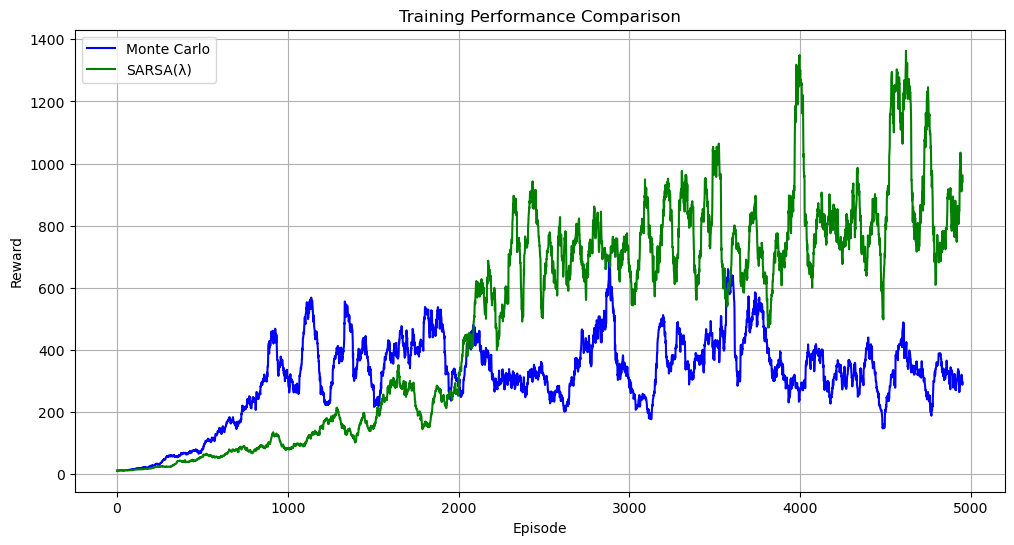

In [167]:
plot_training_curves(mc_rewards, sarsa_rewards, window=50)


=== Monte Carlo Agent ===


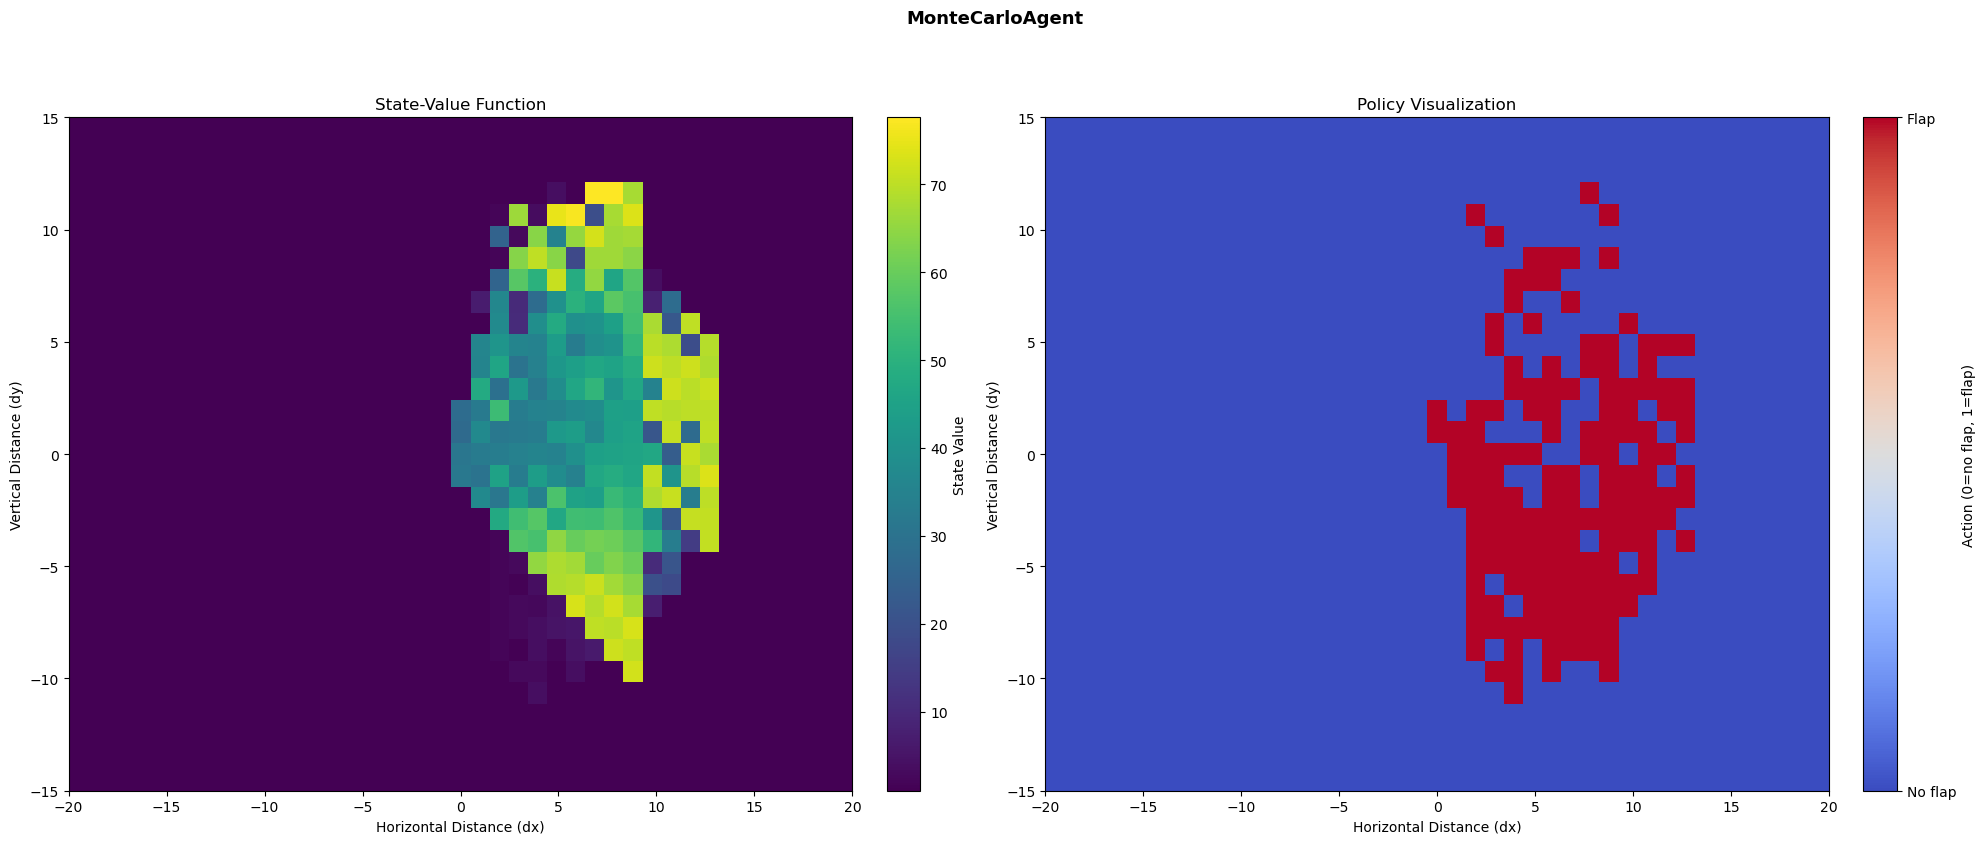


=== SARSA(λ) Agent ===


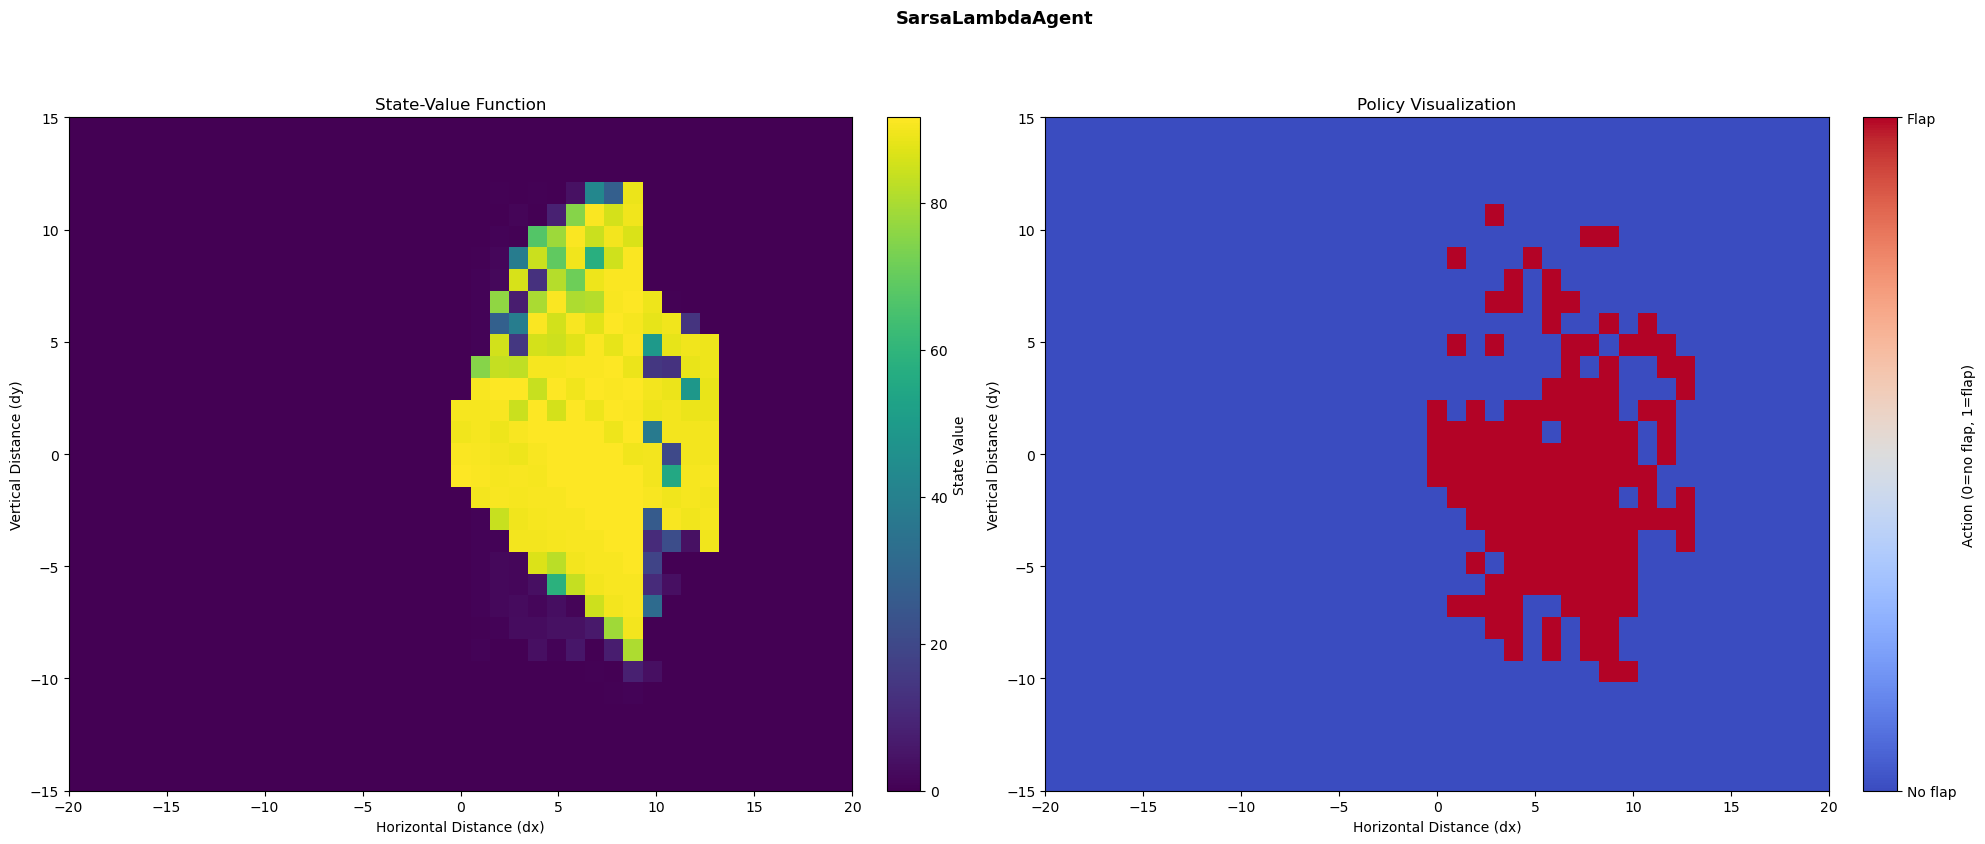

In [186]:
# Visualize state values and policies
for name, agent in [('Monte Carlo', mc_agent), ('SARSA(λ)', sarsa_agent)]:
    print(f"\n=== {name} Agent ===")
    plot_agent_visualizations(agent, max_dx=20, max_dy=15)

In [169]:
#render_trained_agent(env, mc_agent)

In [170]:
#render_trained_agent(env, sarsa_agent)

#### Learning Rate ($\alpha$) Sensitivity

In [171]:
def plot_alpha_sensitivity(env, episodes=500):
    """Compare performance across different learning rates"""
    alphas = [0.01, 0.05, 0.1, 0.2, 0.5]
    
    plt.figure(figsize=(14, 6))
    
    # Monte Carlo
    plt.subplot(1, 2, 1)
    for alpha in alphas:
        agent = MonteCarloAgent(env, alpha=alpha)
        rewards = agent.train(episodes,print_progression=False)
        plt.plot(moving_average(rewards, 50), label=f'α={alpha}')
    plt.title('Monte Carlo Learning Rate Sensitivity')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Reward')
    plt.legend()
    plt.grid(True)
    
    # SARSA(λ)
    plt.subplot(1, 2, 2)
    for alpha in alphas:
        agent = SarsaLambdaAgent(env, alpha=alpha, lambda_=0.7)
        rewards = agent.train(episodes,print_progression=False)
        plt.plot(moving_average(rewards, 50), label=f'α={alpha}')
    plt.title('SARSA(λ) Learning Rate Sensitivity')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Reward')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

#### Discount Factor ($\gamma$) Sensitivity

In [172]:
def plot_gamma_sensitivity(env, episodes=500):
    """Compare performance across different discount factors"""
    gammas = [0.9, 0.95, 0.99, 0.999]
    
    plt.figure(figsize=(14, 6))
    
    # Monte Carlo
    plt.subplot(1, 2, 1)
    for gamma in gammas:
        agent = MonteCarloAgent(env, gamma=gamma)
        rewards = agent.train(episodes,print_progression=False)
        plt.plot(moving_average(rewards, 50), label=f'γ={gamma}')
    plt.title('Monte Carlo Discount Factor Sensitivity')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Reward')
    plt.legend()
    plt.grid(True)
    
    # SARSA(λ)
    plt.subplot(1, 2, 2)
    for gamma in gammas:
        agent = SarsaLambdaAgent(env, gamma=gamma, lambda_=0.7)
        rewards = agent.train(episodes,print_progression=False)
        plt.plot(moving_average(rewards, 50), label=f'γ={gamma}')
    plt.title('SARSA(λ) Discount Factor Sensitivity')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Reward')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

#### Eligibility Trace Decay ($\lambda$) Sensitivity (SARSA only)

In [173]:
def plot_lambda_sensitivity(env, episodes=500):
    """Compare SARSA performance across different lambda values"""
    lambdas = [0, 0.3, 0.5, 0.7, 0.9, 1.0]
    
    plt.figure(figsize=(14, 6))
    
    for lambda_ in lambdas:
        agent = SarsaLambdaAgent(env, lambda_=lambda_)
        rewards = agent.train(episodes,print_progression=False)
        plt.plot(moving_average(rewards, 50), label=f'λ={lambda_}')
    
    plt.title('SARSA(λ) Eligibility Trace Sensitivity')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Convergence Analysis

In [ ]:
def calculate_stability_metrics(rewards, window):
    moving_avg = np.convolve(rewards, np.ones(window) / window, mode='valid')
    return {
        'mean': np.mean(rewards[-window:]),
        'std': np.std(rewards[-window:]),
        'convergence_episode': len(rewards) - np.argmax(moving_avg > 0.9 * np.max(moving_avg)),
        'moving_avg': moving_avg
    }

def prepare_ci(data, num_runs):
    means = [d['mean'] for d in data]
    stds = [d['std'] for d in data]
    conv_eps = [d['convergence_episode'] for d in data]
    return {
        'avg_mean': np.mean(means),
        'avg_std': np.mean(stds),
        'avg_conv': np.mean(conv_eps),
        'ci_mean': 1.96 * np.std(means) / np.sqrt(num_runs),
        'ci_std': 1.96 * np.std(stds) / np.sqrt(num_runs),
        'moving_avgs': [d['moving_avg'] for d in data]
    }

def plot_moving_averages(stats, label, color):
    for ma in stats['moving_avgs']:
        plt.plot(ma, color=color, alpha=0.2)
    plt.plot(np.mean(stats['moving_avgs']), color=color,
             label=f'{label} (μ={stats["avg_mean"]:.1f}±{stats["ci_mean"]:.1f})')
    plt.title(f'Moving Average Rewards (100-ep window)')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)

def plot_convergence_metrics(env, num_runs=5, episodes=1000, window_size=100):
    mc_data = []
    sarsa_data = []
    for _ in range(num_runs):
        mc_agent = MonteCarloAgent(env)
        mc_rewards = mc_agent.train(episodes, print_progression=False)
        mc_data.append(calculate_stability_metrics(mc_rewards, window_size))
        
        sarsa_agent = SarsaLambdaAgent(env, lambda_=0.7)
        sarsa_rewards = sarsa_agent.train(episodes, print_progression=False)
        sarsa_data.append(calculate_stability_metrics(sarsa_rewards, window_size))
    
    mc_stats = prepare_ci(mc_data, num_runs)
    sarsa_stats = prepare_ci(sarsa_data, num_runs)
    
    plt.figure(figsize=(14, 6))
    plot_moving_averages(mc_stats, 'Monte Carlo', 'blue')
    plot_moving_averages(sarsa_stats, 'SARSA(λ)', 'orange')
    plt.show()
    
    print("\nMonte Carlo Convergence:")
    print(f"- Final reward: {mc_stats['avg_mean']:.1f} ± {mc_stats['ci_mean']:.1f}")
    print(f"- Reward std: {mc_stats['avg_std']:.1f} ± {mc_stats['ci_std']:.1f}")
    print(f"- Converged after: {mc_stats['avg_conv']:.0f} episodes")
    
    print("\nSARSA(λ) Convergence:")
    print(f"- Final reward: {sarsa_stats['avg_mean']:.1f} ± {sarsa_stats['ci_mean']:.1f}")
    print(f"- Reward std: {sarsa_stats['avg_std']:.1f} ± {sarsa_stats['ci_std']:.1f}")
    print(f"- Converged after: {sarsa_stats['avg_conv']:.0f} episodes")

In [ ]:
def compare_final_performance(env, num_runs=10, episodes=500):
    """Compare final performance across multiple runs with enhanced visualization"""
    mc_final = []
    sarsa_final = []
    
    for _ in range(num_runs):
        # Monte Carlo
        mc_agent = MonteCarloAgent(env)
        mc_rewards = mc_agent.train(episodes, print_progression=False)
        mc_final.append(np.mean(mc_rewards[-100:]))
        
        # SARSA(λ)
        sarsa_agent = SarsaLambdaAgent(env, lambda_=0.7)
        sarsa_rewards = sarsa_agent.train(episodes, print_progression=False)
        sarsa_final.append(np.mean(sarsa_rewards[-100:]))
    
    plt.figure(figsize=(6, 10), facecolor='white')
    ax = plt.gca()

    boxprops = dict(linestyle='-', linewidth=2, color='black')
    whiskerprops = dict(linestyle='-', linewidth=1.5, color='gray')
    capprops = dict(linestyle='-', linewidth=1.5, color='gray')
    medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
    
    boxes = plt.boxplot([mc_final, sarsa_final], 
                       labels=['Monte Carlo', 'SARSA(λ)'],
                       patch_artist=True,
                       boxprops=boxprops,
                       whiskerprops=whiskerprops,
                       capprops=capprops,
                       medianprops=medianprops,
                       widths=0.6)

    colors = ['lightblue', 'lightgreen']
    for patch, color in zip(boxes['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    for i, (mc, sarsa) in enumerate(zip(mc_final, sarsa_final)):
        plt.scatter([1, 2], [mc, sarsa], color='black', alpha=0.4, s=60, edgecolor='white', linewidth=1)
    
    ax.grid(True, linestyle='--', alpha=0.6)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    
    plt.title('Final Performance Comparison\n(100-episode moving average)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Algorithm', fontsize=12, labelpad=10)
    plt.ylabel('Average Reward', fontsize=12, labelpad=10)
    
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    ax.yaxis.grid(True, linestyle=':', alpha=0.4)

    stats_text = (f"Monte Carlo: μ = {np.mean(mc_final):.1f} ± {np.std(mc_final):.1f}\n"
                  f"SARSA(λ): μ = {np.mean(sarsa_final):.1f} ± {np.std(sarsa_final):.1f}")
    plt.text(0.02, 0.98, stats_text, 
             transform=ax.transAxes, 
             verticalalignment='bottom',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    plt.tight_layout()
    plt.show()

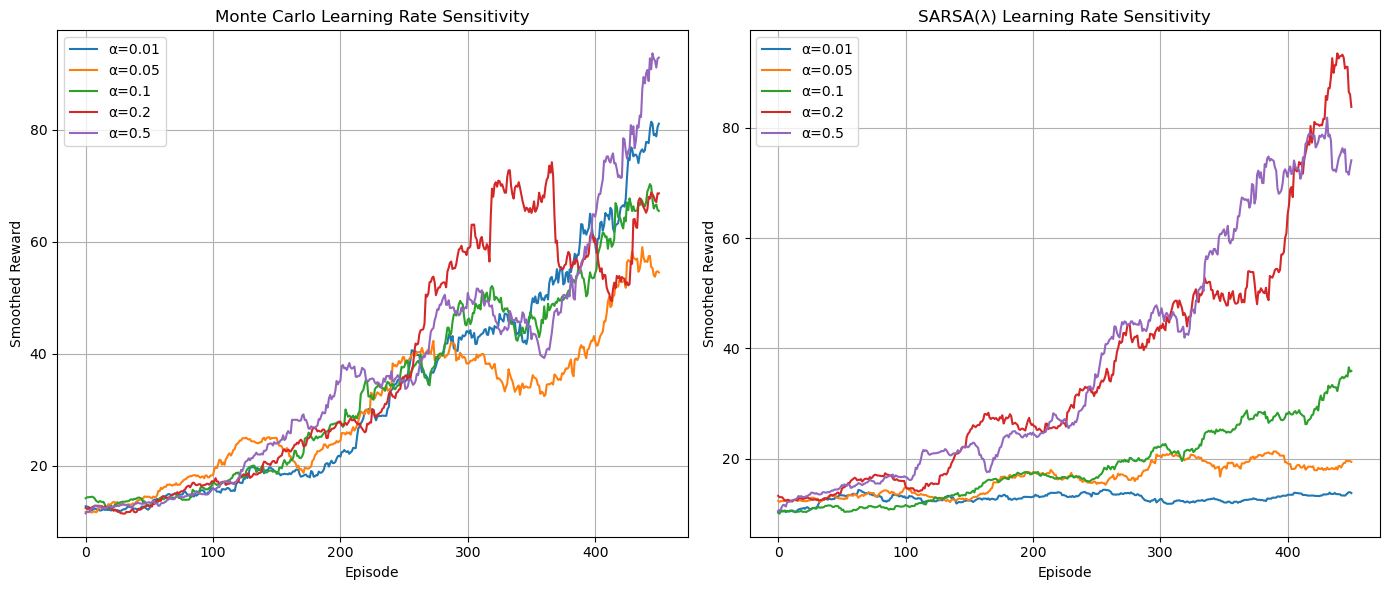

In [176]:
plot_alpha_sensitivity(env)

- Monte Carlo generally tolerates higher learning rates better

- SARSA(λ) shows more sensitivity to extreme α values

- Optimal α range appears to be 0.1-0.2 for both algorithms

- Very low α (0.01) leads to slow learning in both cases

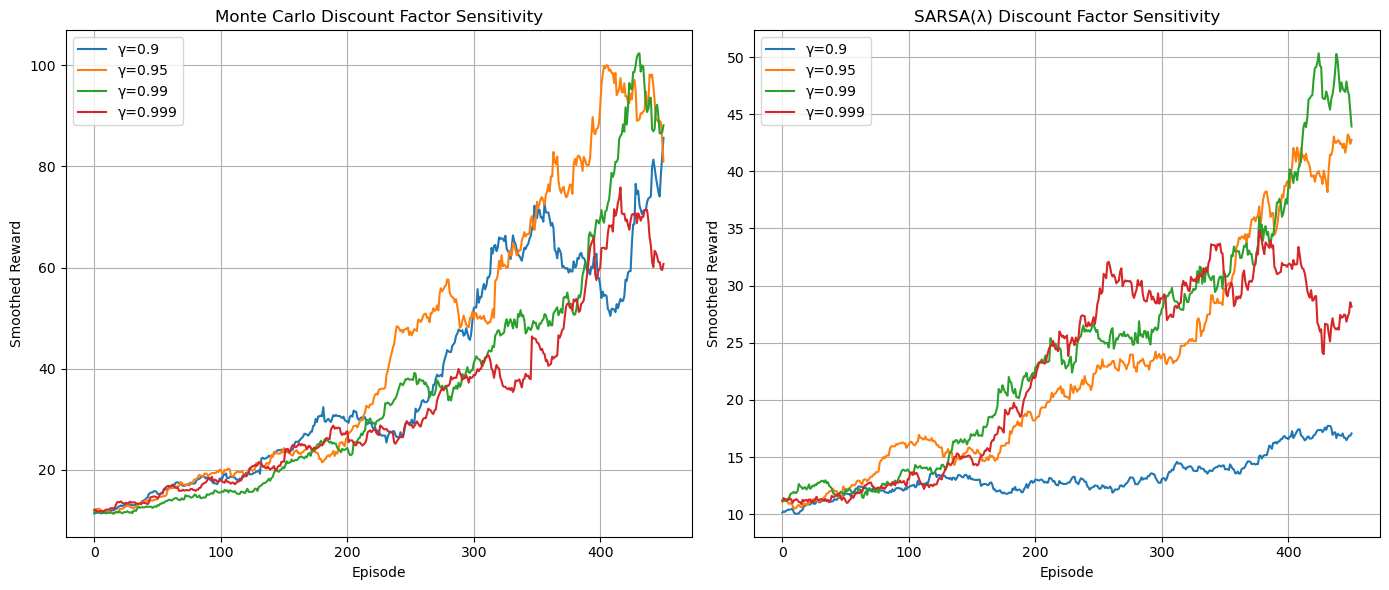

In [177]:
plot_gamma_sensitivity(env)

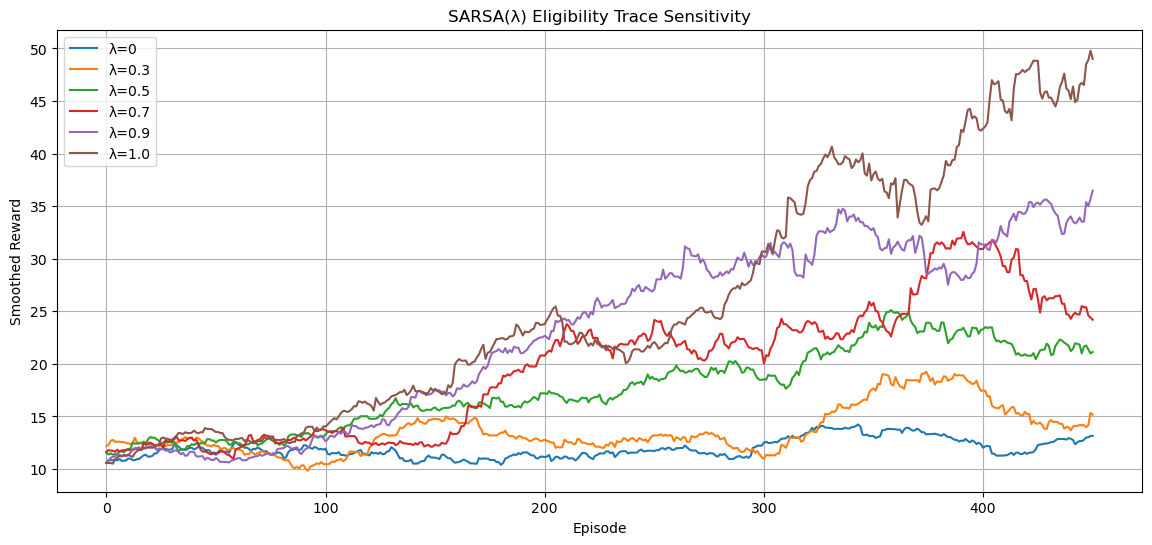

In [178]:
plot_lambda_sensitivity(env)  # For SARSA only

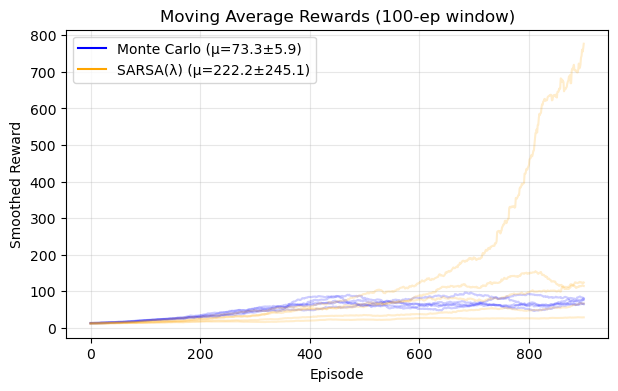


Monte Carlo Convergence:
- Final reward: 73.3 ± 5.9
- Reward std: 67.9 ± 12.0
- Converged after: 452 episodes

SARSA(λ) Convergence:
- Final reward: 222.2 ± 245.1
- Reward std: 200.4 ± 235.9
- Converged after: 202 episodes


In [179]:
plot_convergence_metrics(env, num_runs=5, episodes=1000, window_size=100)

/var/folders/dl/9bz5fwk55z906gm27_x9mgbc0000gn/T/ipykernel_33823/4018824268.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes = plt.boxplot([mc_final, sarsa_final],


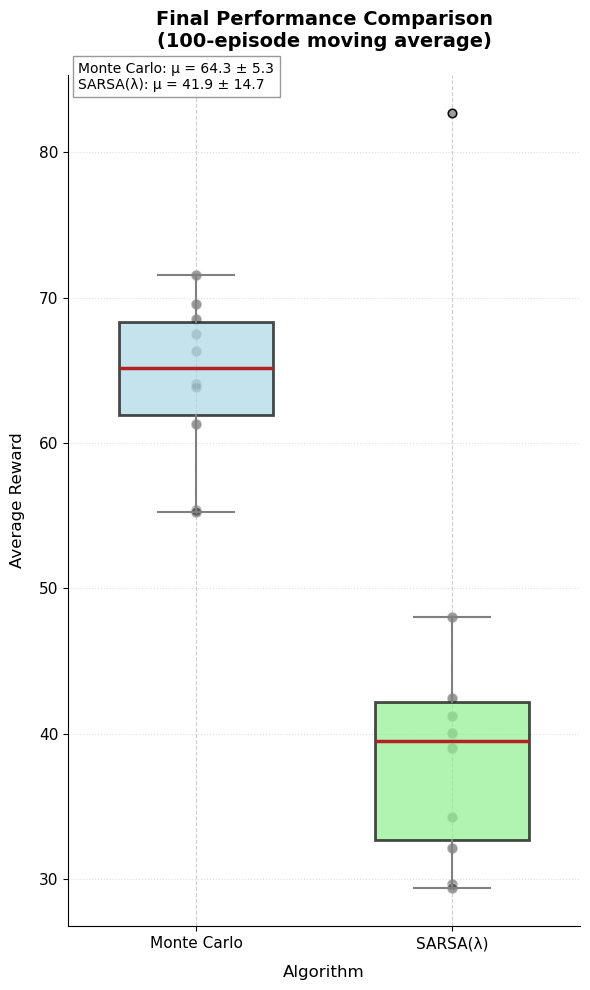

In [180]:
compare_final_performance(env, num_runs=10)

### 2. How are the two versions of the TFB environment different? What are the main limitations of using one or the other environment?

The two versions of the TextFlappyBird (TFB) environment differ primarily in their observation space, which significantly impacts training difficulty, computational requirements, and algorithm suitability:

### 3. With an implementation of the original flappy bird game environment available, can the same agents be used?

The same agents cannot be directly used without modifications due to differences in observation space and environment dynamics. However, with some adaptations, the core learning algorithms (e.g., Q-Learning, SARSA, DQN) can still be applied.

### 4. Given a trained agent on a specific configuration of the TFB environment (e.g., height=15, width=20, pipe gap=4) how well the trained agent performs on a different level configuration?

In [192]:
def test_agent_performance(agent, env_config, test_episodes=1000):
    """Test agent on specific configuration, returning average reward"""
    test_env = gym.make("TextFlappyBird-v0", **env_config)
    rewards = []
    
    for _ in range(test_episodes):
        obs, _ = test_env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            # Extract the state tuple from observation
            if isinstance(obs, tuple):
                state = obs[0]  # (player_y, pipe_dist_x)
            else:
                state = obs
            
            # Get action from policy
            action = agent.policy.get(state, 0)  # Default to action 0
            
            obs, reward, done, _, _ = test_env.step(action)
            episode_reward += reward
            
            # Early termination if stuck (prevent infinite loops)
            if episode_reward > 1000:  # Unrealistically high score
                done = True
                reward = 0  # Count as failure
                
        rewards.append(episode_reward)
    
    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    
    # Filter out zero-reward episodes for success rate
    success_rate = np.mean([1 if r > 0 else 0 for r in rewards])
    
    return avg_reward, std_reward, success_rate

def compare_agents(mc_agent, sarsa_agent, test_configs):
    """Compare agent performance with proper metrics"""
    results = {}
    
    for config in test_configs:
        print(f"\nTesting config: {config}")
        
        # Test Monte Carlo
        print("Testing Monte Carlo...")
        mc_avg, mc_std, mc_success = test_agent_performance(mc_agent, config)
        
        # Test SARSA
        print("Testing SARSA...")
        sarsa_avg, sarsa_std, sarsa_success = test_agent_performance(sarsa_agent, config)
        
        key = f"H={config['height']},W={config['width']},G={config['pipe_gap']}"
        results[key] = {
            'MonteCarlo': {'avg': mc_avg, 'std': mc_std, 'success': mc_success},
            'SARSA': {'avg': sarsa_avg, 'std': sarsa_std, 'success': sarsa_success}
        }
        
        print(f"MC: Avg={mc_avg:.1f}±{mc_std:.1f} (Success={mc_success:.1%})")
        print(f"SARSA: Avg={sarsa_avg:.1f}±{sarsa_std:.1f} (Success={sarsa_success:.1%})")
    
    return results

In [194]:
# Test configurations
test_configs = [
    {'height':15, 'width':20, 'pipe_gap':4},  # Original
    {'height':150, 'width':20, 'pipe_gap':4},  # Taller
    {'height':15, 'width':200, 'pipe_gap':4},  # Wider
    {'height':15, 'width':200, 'pipe_gap':10},  # Big Pipe Gap
]

#results = compare_agents(mc_agent, sarsa_agent, test_configs)